<a href="https://colab.research.google.com/github/balcomes/VAEs-in-Economics/blob/master/Tuner2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip uninstall tensorflow
#!pip install tensorflow
#!pip install keras-tuner
#!git clone https://github.com/yaniv256/VAEs-in-Economics.git

In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
!nvidia-smi

Fri Mar  6 04:58:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    38W / 250W |   1423MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from tensorflow.keras import backend as K   # Use tensorflow.keras
K.clear_session()

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from numpy.random import seed

import numpy as np

In [0]:
epochs = 8
batch_size = 32

In [0]:
import pandas as pd 
df=pd.read_csv("https://github.com/yaniv256/VAEs-in-Economics/blob/master/Data/Timeuse/time_shares_only_2013.csv?raw=true")
df.head()

Sleeping  ...  Public_health_activities
0       540  ...                         0
1       580  ...                         0
2       450  ...                         0
3       450  ...                         0
4       570  ...                         0

[5 rows x 389 columns]

In [0]:
from sklearn.preprocessing import QuantileTransformer

qt_trans = QuantileTransformer(n_quantiles=1000, random_state=0)
qt = pd.DataFrame(qt_trans.fit_transform(df))
qt.columns = df.columns
qt.head()

Sleeping  ...  Public_health_activities
0  0.571572  ...                       0.0
1  0.693193  ...                       0.0
2  0.262262  ...                       0.0
3  0.262262  ...                       0.0
4  0.663163  ...                       0.0

[5 rows x 389 columns]

In [0]:
from sklearn.model_selection import train_test_split 
x_train, x_test = train_test_split(qt, test_size=0.33, random_state=42)
train_examples = x_train.shape[0]
flag_0 = np.zeros((train_examples,1),dtype=x_train.values.dtype)
x_train = np.concatenate((x_train.values,flag_0),axis=-1)
test_examples = x_test.shape[0]
flag_1 = np.ones((test_examples,1),dtype=x_test.values.dtype)
x_test = np.concatenate((x_test.values,flag_1),axis=-1)

print(x_train.shape)
print(x_test.shape)

(7627, 390)
(3758, 390)


In [0]:
import tensorflow.keras as keras
keras.__version__

from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
#from tensorflow import set_random_seed

from numpy.random import seed

import numpy as np
import pandas as pd

from tensorflow.keras.callbacks import TensorBoard

from datetime import datetime

def make_vae( full_data,
    plot_types_args = {}, 
    img_shape = (389+1, ),
    latent_dim = 1, 
    dense_width = 1024,
    l2_penalty=0.0,
    l1_penalty=0.0,
    encoder_dropout_rate=0.5,
    decoder_dropout_rate=0.5,
    entanglement_penalty = 2,
    hidden_n = 2, 
    lr_factor = 0.9,
    lr_patience = 30):
  
  class PlotEpoch(keras.callbacks.Callback):

      def on_epoch_end(self, epoch, logs={}):
          
        if epoch % 100 == 0:
          plot_types(encoder = self.model.encoder, 
                    decoder = self.model.decoder, 
                    data = self.model.full_data, 
                    **plot_types_args)
          
  plot_epoch = PlotEpoch()

  now = datetime.now()
  logdir = "tf_logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"

  callback_list = [
                  keras.callbacks.ReduceLROnPlateau(
                      monitor = 'val_loss',
                      factor = lr_factor,
                      patience = lr_patience,
                      verbose = 1 #true
                  ),
                  plot_epoch,
                  #keras.callbacks.ModelCheckpoint(filepath=logdir,
                  #                                mode='max',
                  #                                monitor='val_accuracy',
                  #                                verbose=2,
                  #                                save_best_only=True),
                  TensorBoard(log_dir=logdir, histogram_freq=0)
  ]

  input_img = keras.Input(shape=img_shape)

  # The last input indicate to the network whether this is validation
  is_validation = input_img[:,-1] 
  input_data = input_img[:,:-1]

  input_data = layers.GaussianNoise(0.03*(1-K.mean(is_validation)))(input_data)

  x = layers.Dense(dense_width, activation=layers.PReLU(alpha_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty)), \
                   kernel_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty))(input_data)



  x = layers.Dropout(encoder_dropout_rate)(x)

  for i in range(hidden_n):
    x = layers.Dense(dense_width, activation=layers.PReLU(alpha_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty)), 
                     kernel_regularizer=regularizers.l1_l2(
                        l1=l1_penalty,l2=l2_penalty))(x)
    x = layers.Dropout(encoder_dropout_rate)(x)

  z_mean = layers.Dense(latent_dim)(x)
  z_log_var = layers.Dense(latent_dim)(x)
  
  # Reduce sampling variance to near zero on validation (idea credit: Shahaf Grofit)
  is_validation_change = is_validation*100
  z_log_var = keras.layers.Subtract()([z_log_var, is_validation_change])
 
  def sampling(args):
      z_mean, z_log_var = args
      epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                mean=0., stddev=1.)
      return z_mean + K.exp(z_log_var) * epsilon

  class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        is_validation = x[:,-1] 
        input_data = x[:,:-1] 
        x = K.flatten(input_data)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.mse(x, z_decoded)

        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) 
            - entanglement_penalty*K.exp(z_log_var), axis=-1)
        
        # Penalize for variance, but only in training 
        return K.mean(xent_loss + (1-is_validation)*kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x    

  z = layers.Lambda(sampling)([z_mean, z_log_var])

  encoder = Model(input_img,z_mean) # Maybe better if Model(input_data,z_mean)

  # This is the input where we will feed `z`.
  decoder_input = layers.Input(K.int_shape(z)[1:])
  print(decoder_input.shape)
  x = layers.Dense(dense_width, 
                   activation=layers.PReLU(alpha_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty)),
                   kernel_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty))(decoder_input)
  x = layers.Dropout(decoder_dropout_rate)(x)

  for i in range(hidden_n):
    x = layers.Dense(dense_width, 
                     activation=layers.PReLU(alpha_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty)),
                      kernel_regularizer=regularizers.l1_l2(
                        l1=l1_penalty,l2=l2_penalty))(x)
    x = layers.Dropout(decoder_dropout_rate)(x)


  x = layers.Dense(img_shape[0]-1, 
                    kernel_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty))(x)

  # This is our decoder model.
  decoder = Model(decoder_input, x)

  # We then apply it to `z` to recover the decoded `z`.
  z_decoded = decoder(z)

  # We call our custom layer on the input and the decoded output,
  # to obtain the score. Note that the objective is computed by 
  # this special final layer.
  y = CustomVariationalLayer()([input_img, z_decoded])

  vae = Model(input_img, y)

  vae.compile(optimizer='adam', loss=None) 
  vae.encoder = encoder
  vae.decoder = decoder
  vae.full_data = full_data
  vae.callback_list = callback_list

  return vae

In [0]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

sns.set()
sns.set_style("darkgrid")

def plot_types(encoder, decoder, data, 
               n_type = 60, each_hight = 20, approx_width=400, 
               frac_width =0.55, 
               n_activity =  90, lowest_percentile= 1, 
               highest_percentile = 99, figsize=(10, 37),
               cmap='viridis', n_xlabels=13, spacing = -0.005, 
               hist_size=0.08, scaler=True):
  
  # definitions for the axes
  left, width = 0.05, frac_width
  bottom, height = 0.025, 0.65
  
  rect_scatter = [left, bottom, width, height]
  rect_histx = [left, bottom + height + spacing, width, hist_size]
  rect_colorbar = [left+width+0.1, bottom + height + spacing +0.01, width, 0.02]

  # start with a rectangular Figure
  plt.figure(figsize=figsize)

  ax_scatter = plt.axes(rect_scatter)
  ax_scatter.tick_params(direction='in', top=True, right=True)
  ax_histx = plt.axes(rect_histx)
  ax_histx.tick_params(direction='in', labelbottom=False)
  ax_colorbar = plt.axes(rect_colorbar)
  ax_colorbar.tick_params(direction='in', labelbottom=False, labelleft=False)

  each_width = np.int(np.ceil(approx_width/n_type))
  figure = np.zeros((each_hight*n_activity,n_type*each_width))
  # Linearly spaced coordinates on the unit square were transformed
  # through the inverse CDF (ppf) of the Gaussian
  # to produce values of the latent variables z,
  # since the prior of the latent space is Gaussian
  
  # We need to add a column of ones to indicate validation
  test_examples = data.shape[0]
  flag_1 = np.ones((test_examples,1),dtype=data.values.dtype)
  data_mat = np.concatenate((data.values,flag_1),axis=-1)
  encoded_data=encoder.predict(data_mat)


  lowest=np.percentile(encoded_data, lowest_percentile)
  highest=np.percentile(encoded_data, highest_percentile)

  grid_x = np.linspace(lowest, highest, n_type)

  for i, xi in enumerate(grid_x):
      z_sample = np.array([[xi]])
      x_decoded = decoder.predict(z_sample)
      figure[0:n_activity*each_hight,i*each_width : (i + 1)*each_width] = \
      np.repeat(x_decoded[0,0:n_activity],each_hight).reshape(n_activity*each_hight,1)

  if scaler:
    figure=np.transpose(figure)
    scaler = MinMaxScaler()
    figure=scaler.fit_transform(figure)
    figure=np.transpose(figure)

  im = ax_scatter.imshow(figure, cmap=cmap)
  plt.colorbar(im, ax= ax_colorbar, orientation='horizontal', fraction=1)

  for i in range(n_activity):

    ax_scatter.text(1.02*n_type*each_width,
                    0.8*each_hight+i*each_hight, 
                    data.columns[i], fontsize=14)

  bins=np.append(grid_x-(grid_x[1]-grid_x[0])/2,
                 grid_x[n_type-1]+(grid_x[1]-grid_x[0])/2)

  
  ax_scatter.set_xticks( np.linspace(0,n_type*each_width,n_xlabels))
  ax_scatter.set_xticklabels(np.round(np.linspace(bins[0], bins[n_type], n_xlabels),
                                      decimals=2))  
  ax_scatter.set_yticks([])

  ax_histx.set_xticks( np.linspace(bins[0], bins[n_type], n_xlabels))
  
  sns.distplot(encoded_data,ax=ax_histx,bins=bins,kde=False,
               rug=False).set_xlim(bins[0],bins[n_type])

  plt.savefig('type_plot.png')

  plt.show()

In [0]:
def encode_plot2d(
    encoder, 
    decoder,
    data,
    x_col = 'Work__main_job',
    y_col = 'Physical_care_for_hh_children',
    lowest_percentile=1,
    highest_percentile = 99,
    n=70,
    step=10):

  test_examples = data.shape[0]
  flag_1 = np.ones((test_examples,1),dtype=data.values.dtype)
  data_mat = np.concatenate((data.values,flag_1),axis=-1)
  encoded_data=encoder.predict(data_mat)

  lowest=np.percentile(encoded_data, lowest_percentile)
  highest=np.percentile(encoded_data, highest_percentile)

  grid_x = np.linspace(lowest, highest, n)

  filtered=pd.DataFrame((decoder.predict(grid_x)))
  scaler = MinMaxScaler()
  filtered=pd.DataFrame(scaler.fit_transform(filtered))
  filtered.columns = data.columns
  
  sns.kdeplot(data[x_col], data[y_col], cmap="Blues", shade=True, bw=.2, 
              cut=0.1, legend=True)
  sns.lineplot(x = filtered[x_col], y=filtered[y_col], linewidth=1.5, 
                color= '#8E3179', sort=False)
  
  for i in range(0,n,step):
      plt.text(filtered[x_col][i]+0.01, filtered[y_col][i]+0.01, np.round(grid_x[i],1), 
              horizontalalignment='left', size='small', color='black')
  
  plt.savefig(x_col+'_'+y_col+'.png')
  plt.show()

(None, 1)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 390)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 389)]        0           input_1[0][0]                    
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 389)          0           tf_op_layer_strided_slice_1[0][0]
__________________________________________________________________________________________________
dense (Dense)                   (None, 2048)         800768      gaussian_noise[0][0]             
__________________________________________________________________________________

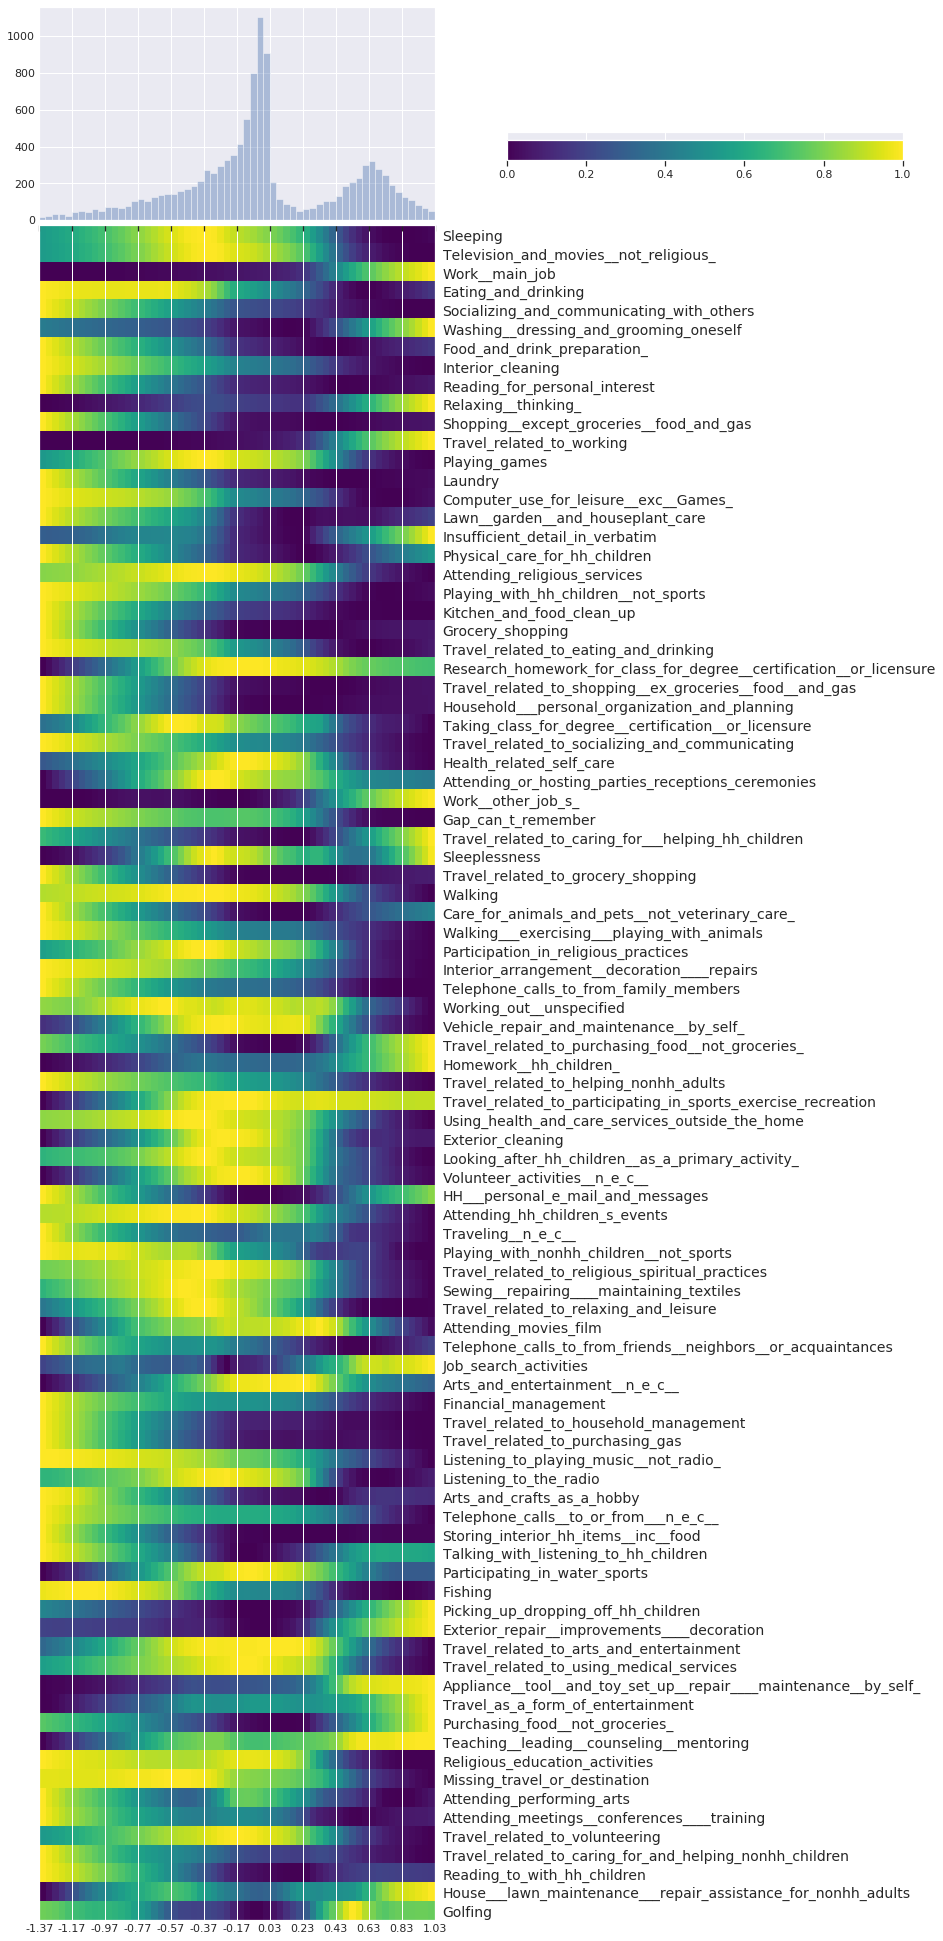

7627/7627 [==============================] - 12s 2ms/sample - loss: 0.0160 - val_loss: 0.0149
Epoch 2/2
7627/7627 [==============================] - 5s 712us/sample - loss: 0.0155 - val_loss: 0.0147
Round number:  2
Train on 7627 samples, validate on 3758 samples
Epoch 1/2
7616/7627 [============================>.] - ETA: 0s - loss: 0.0154

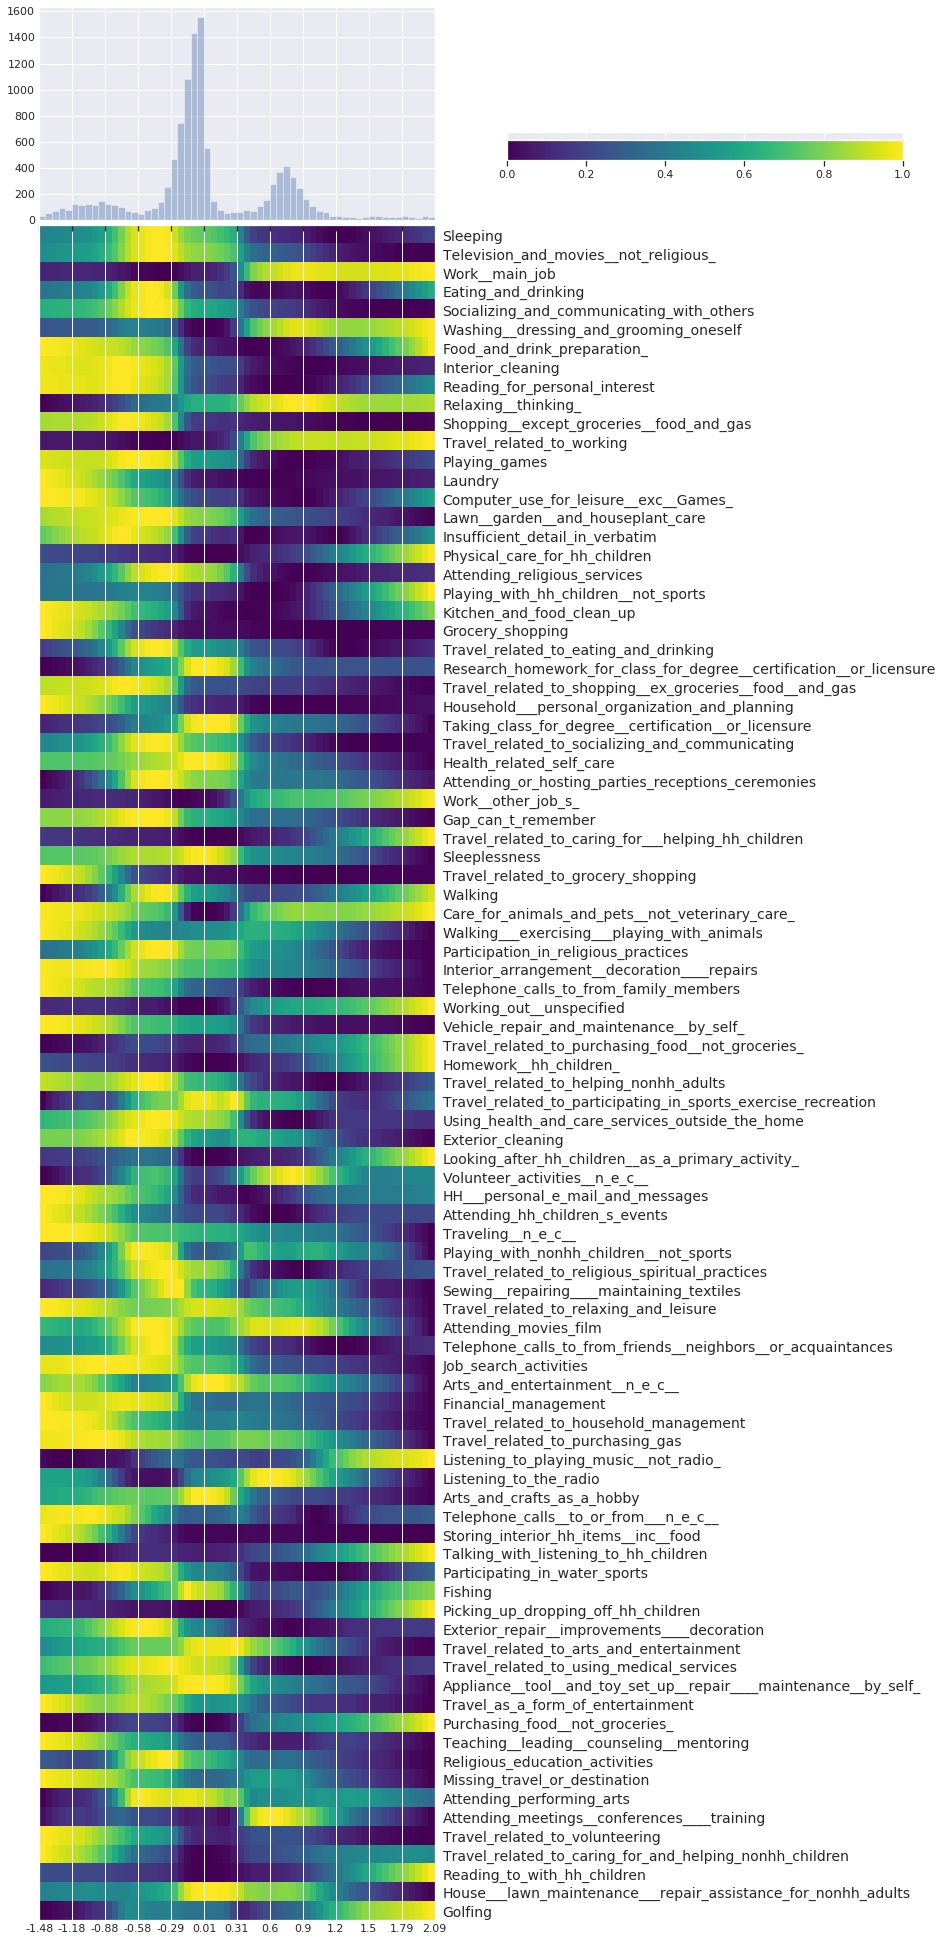

7627/7627 [==============================] - 10s 1ms/sample - loss: 0.0154 - val_loss: 0.0145
Epoch 2/2
7627/7627 [==============================] - 5s 704us/sample - loss: 0.0153 - val_loss: 0.0144
Round number:  3
Train on 7627 samples, validate on 3758 samples
Epoch 1/2
7552/7627 [============================>.] - ETA: 0s - loss: 0.0152

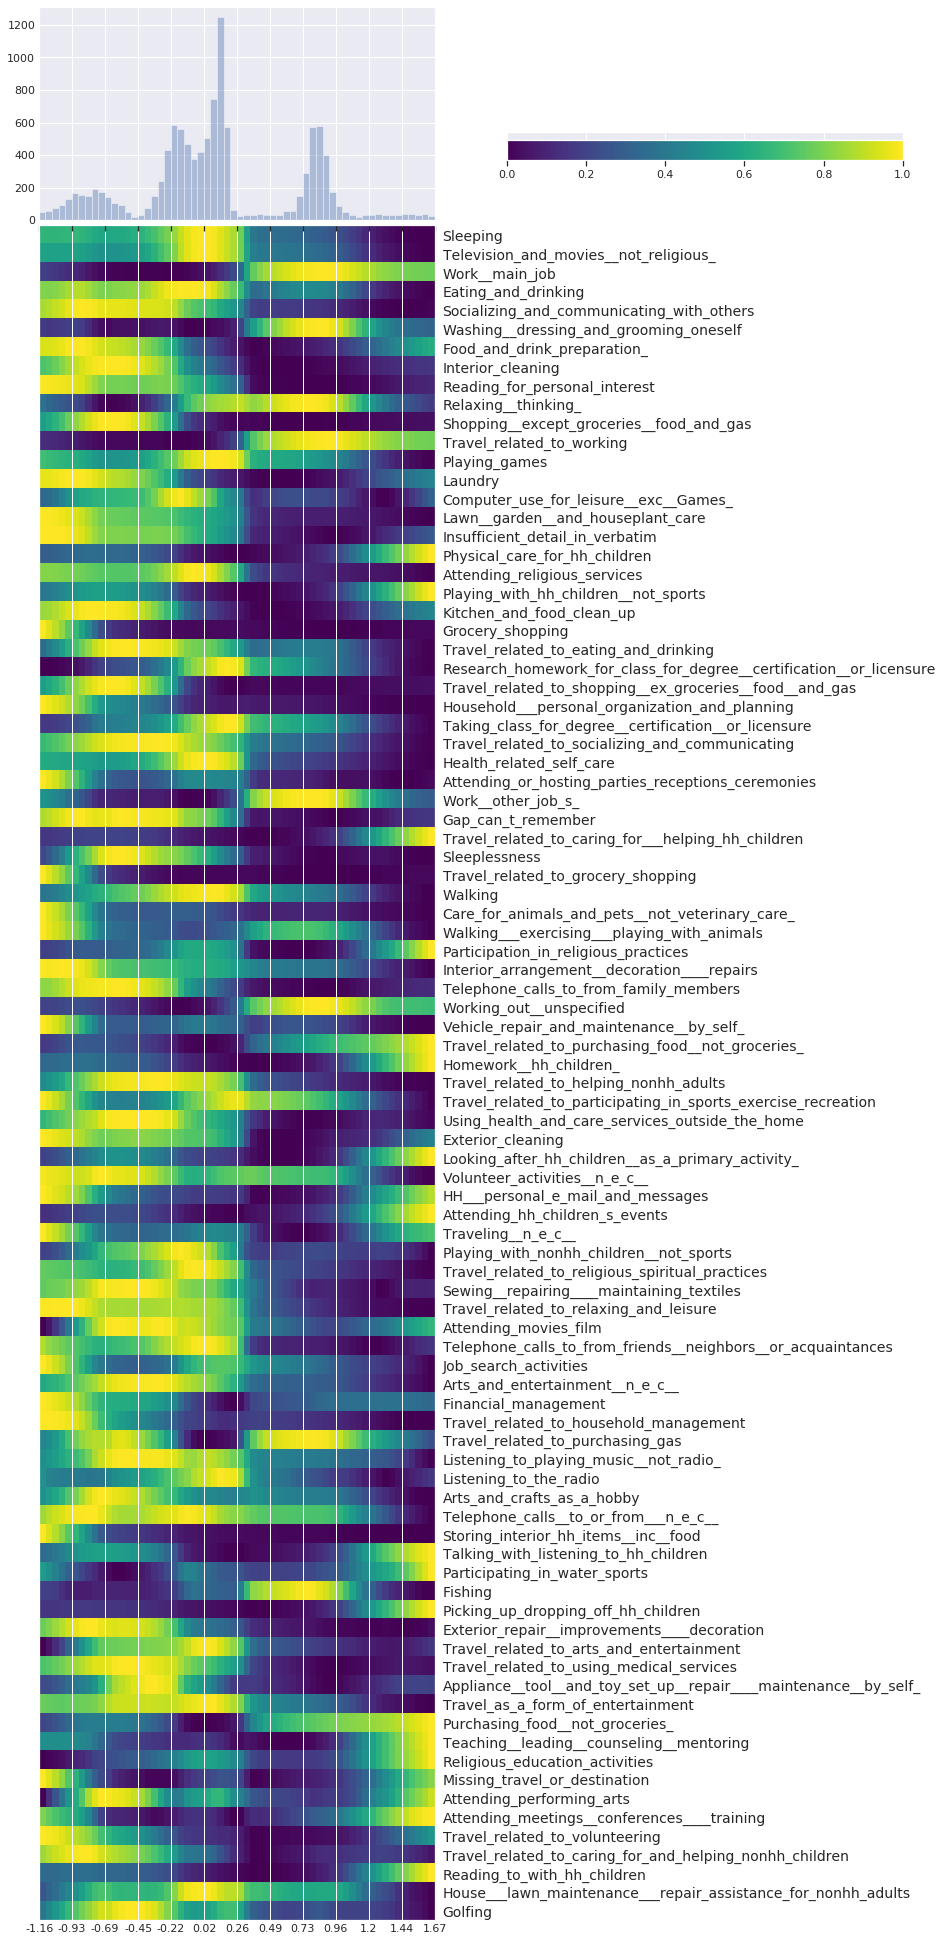

7627/7627 [==============================] - 9s 1ms/sample - loss: 0.0152 - val_loss: 0.0144
Epoch 2/2
7627/7627 [==============================] - 5s 693us/sample - loss: 0.0151 - val_loss: 0.0141
Round number:  4
Train on 7627 samples, validate on 3758 samples
Epoch 1/2
7552/7627 [============================>.] - ETA: 0s - loss: 0.0151

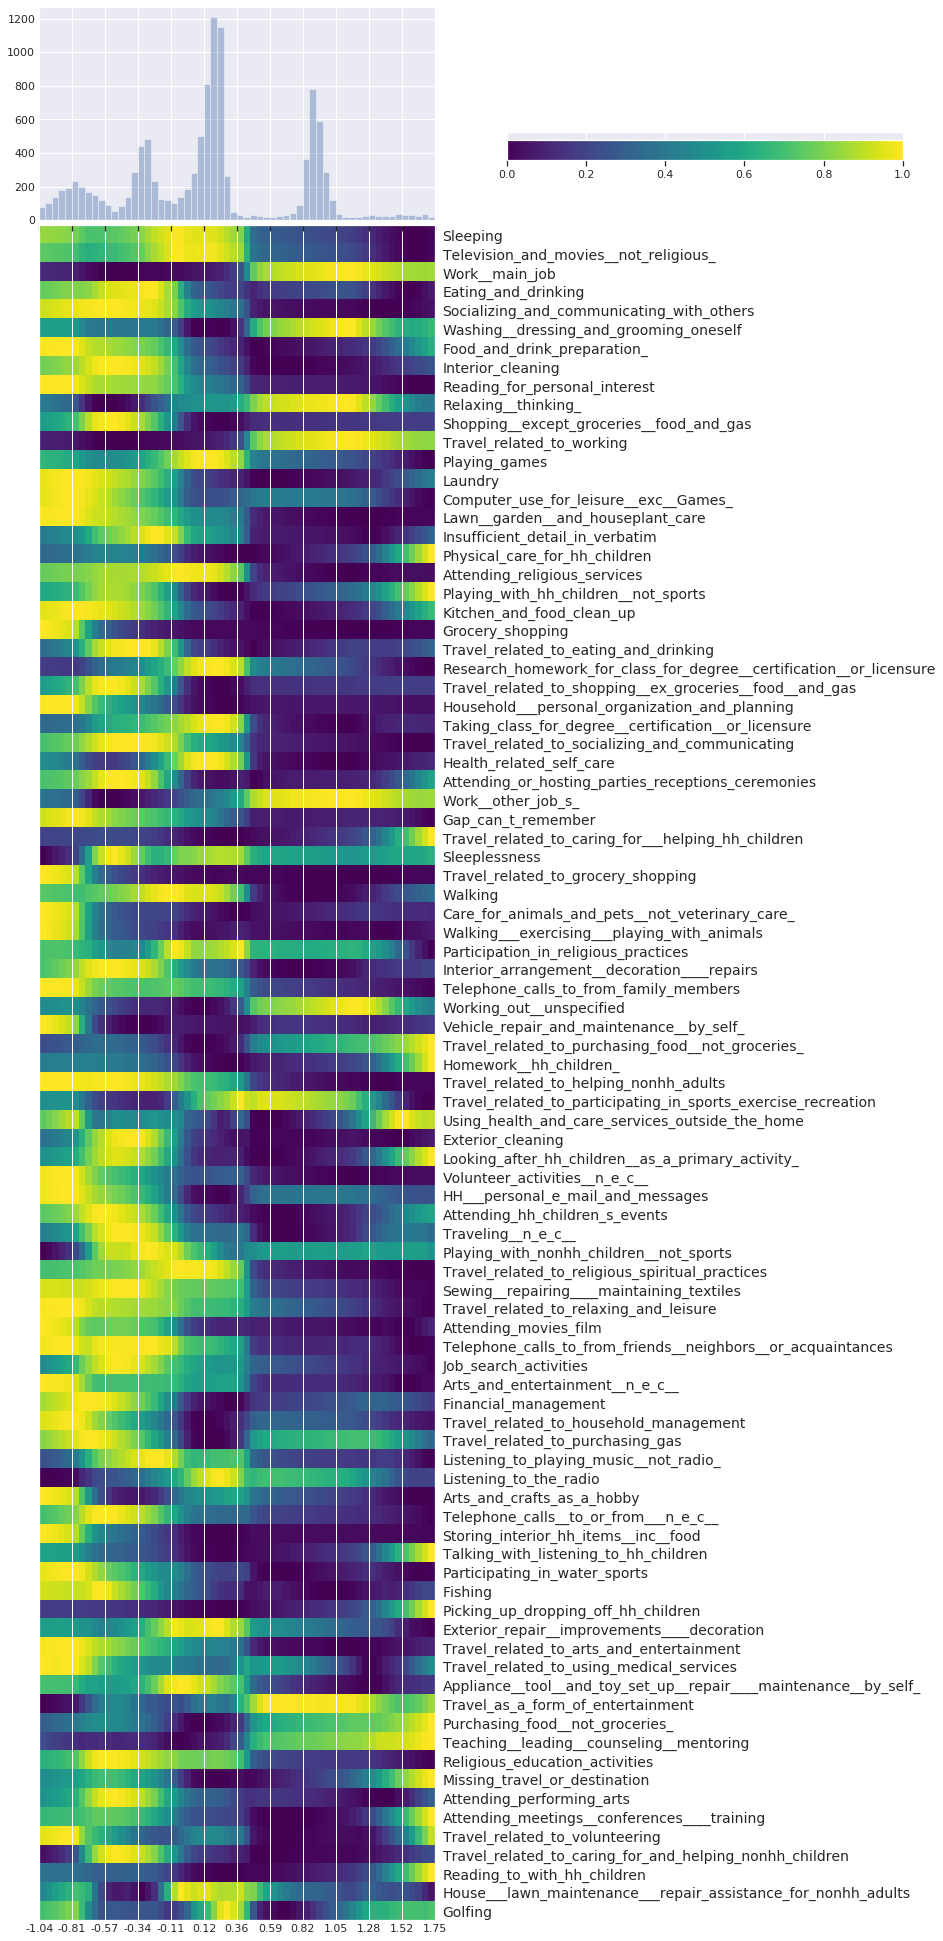

7627/7627 [==============================] - 9s 1ms/sample - loss: 0.0151 - val_loss: 0.0142
Epoch 2/2
7627/7627 [==============================] - 5s 704us/sample - loss: 0.0150 - val_loss: 0.0139


In [0]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

vae = make_vae(full_data=qt,  
    img_shape = (389+1, ),
    latent_dim = 1, 
    dense_width = 2048,
    l2_penalty=0.000000000001,
    l1_penalty=0.0,
    encoder_dropout_rate=0.5,
    decoder_dropout_rate=0.001,
    entanglement_penalty = 2,
    hidden_n = 3)  

vae.summary()

n_starts = 4

for i in range(0,n_starts):

  print("Round number: ", i+1)

  fitted = vae.fit(
      x=x_train, 
      y=None,
      shuffle=True,
      epochs=round(epochs/n_starts),
      batch_size=batch_size,
      validation_data=(x_test, None),
      callbacks = vae.callback_list
      )

In [0]:
import os
all_subdirs = [d for d in os.listdir('./tf_logs') if os.path.isdir('./tf_logs')]
latest_subdir = 'tf_logs/' + max(all_subdirs)
print(latest_subdir)

tf_logs/20200306-045838


In [0]:
%load_ext tensorboard
%tensorboard --logdir="tf_logs"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 254), started 0:21:46 ago. (Use '!kill 254' to kill it.)

<IPython.core.display.Javascript object>

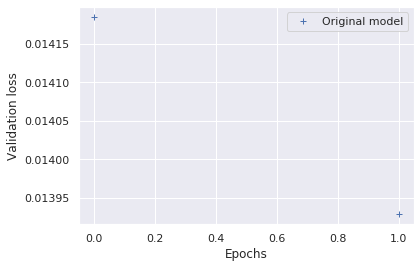

In [0]:
val_loss1 = fitted.history['val_loss']
#val_loss2 = fitted2.history['val_loss']
epochs_grid = range(0, np.shape(val_loss1)[0])

import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs_grid, val_loss1, 'b+', label='Original model')
# "bo" is for "blue dot"
#plt.plot(epochs_grid, val_loss2, 'bo', label='Alternative model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

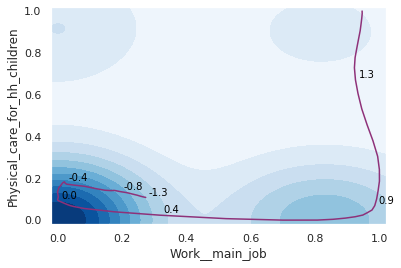

In [0]:
encode_plot2d(encoder=vae.encoder,decoder=vae.decoder, 
                  data=vae.full_data)

In [0]:
flag_1 = np.ones((qt.shape[0],1),dtype=qt.values.dtype)
data = np.concatenate((qt.values,flag_1),axis=-1)
encoded_data=vae.encoder.predict(data)
pd.DataFrame(encoded_data)

0
0      0.087902
1     -1.041408
2     -0.906791
3      0.803367
4      0.071873
...         ...
11380  0.072983
11381  0.783643
11382  0.790706
11383  0.081712
11384  0.013761

[11385 rows x 1 columns]

In [0]:
from sklearn.preprocessing import MinMaxScaler

filtered=pd.DataFrame((vae.decoder.predict(encoded_data)))
scaler = MinMaxScaler()
filtered=pd.DataFrame(scaler.fit_transform(filtered))  
filtered.columns = df.columns
filtered

Sleeping  ...  Public_health_activities
0      0.988327  ...                  0.584678
1      0.651632  ...                  0.339460
2      0.669264  ...                  0.250027
3      0.200178  ...                  0.326829
4      0.985502  ...                  0.592108
...         ...  ...                       ...
11380  0.985708  ...                  0.591577
11381  0.204982  ...                  0.311473
11382  0.203238  ...                  0.316259
11383  0.987273  ...                  0.587164
11384  0.970712  ...                  0.638303

[11385 rows x 389 columns]

In [0]:
filtered-qt

Sleeping  ...  Public_health_activities
0      0.416755  ...                  0.584678
1     -0.041561  ...                  0.339460
2      0.407002  ...                  0.250027
3     -0.062084  ...                  0.326829
4      0.322338  ...                  0.592108
...         ...  ...                       ...
11380  0.723446  ...                  0.591577
11381 -0.082306  ...                  0.311473
11382 -0.633598  ...                  0.316259
11383  0.520306  ...                  0.587164
11384  0.861603  ...                  0.638303

[11385 rows x 389 columns]

In [0]:
import pprint
from kerastuner.tuners import RandomSearch, BayesianOptimization

MAX_TRIALS = 20
EXECUTIONS_PER_TRIAL = 5
TRAIN_EPOCHS = 40

def create_random_tuner(model_builder, project_name):
  tuner = RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTIONS_PER_TRIAL,
    directory='test_dir', 
    project_name=project_name
  )

  tuner.search_space_summary()
  return tuner

def random_search_params(model_builder, project_name):
  tuner = create_random_tuner(model_builder, project_name)
  tuner.search(x=x_train,
             epochs=TRAIN_EPOCHS,
             validation_data=(x_test))
  
  tuner.results_summary()

  pprint(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)

In [0]:
def tune_optimizer_model(hp):
  full_data = qt
  plot_types_args = {}
  img_shape = (389+1, )
  latent_dim = 1
  dense_width = 1024
  l2_penalty=0.0
  l1_penalty=0.0
  encoder_dropout_rate=0.5
  decoder_dropout_rate=0.5
  entanglement_penalty = 2
  hidden_n = 2
  lr_factor = 0.9
  lr_patience = 30
  
  class PlotEpoch(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if epoch % 100 == 0:
        plot_types(encoder = self.model.encoder,
                      decoder = self.model.decoder,
                      data = self.model.full_data,
                      **plot_types_args)
          
  plot_epoch = PlotEpoch()

  now = datetime.now()
  logdir = "tf_logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"

  callback_list = [
                  keras.callbacks.ReduceLROnPlateau(
                      monitor = 'val_loss',
                      factor = lr_factor,
                      patience = lr_patience,
                      verbose = 1 #true
                  ),
                  plot_epoch,
                  TensorBoard(log_dir=logdir, histogram_freq=0)
  ]

  input_img = keras.Input(shape=img_shape)

  # The last input indicate to the network whether this is validation
  is_validation = input_img[:,-1] 
  input_data = input_img[:,:-1]

  input_data = layers.GaussianNoise(0.03*(1-K.mean(is_validation)))(input_data)

  x = layers.Dense(dense_width, activation=layers.PReLU(alpha_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty)), \
                  kernel_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty))(input_data)



  x = layers.Dropout(encoder_dropout_rate)(x)

  for i in range(hidden_n):
    x = layers.Dense(dense_width, activation=layers.PReLU(alpha_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty)), 
                    kernel_regularizer=regularizers.l1_l2(
                        l1=l1_penalty,l2=l2_penalty))(x)
    x = layers.Dropout(encoder_dropout_rate)(x)

  z_mean = layers.Dense(latent_dim)(x)
  z_log_var = layers.Dense(latent_dim)(x)
  
  # Reduce sampling variance to near zero on validation (idea credit: Shahaf Grofit)
  is_validation_change = is_validation*100
  z_log_var = keras.layers.Subtract()([z_log_var, is_validation_change])

  def sampling(args):
      z_mean, z_log_var = args
      epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                mean=0., stddev=1.)
      return z_mean + K.exp(z_log_var) * epsilon

  class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        is_validation = x[:,-1] 
        input_data = x[:,:-1] 
        x = K.flatten(input_data)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.mse(x, z_decoded)

        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) 
            - entanglement_penalty*K.exp(z_log_var), axis=-1)
        
        # Penalize for variance, but only in training 
        return K.mean(xent_loss + (1-is_validation)*kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x 

  z = layers.Lambda(sampling)([z_mean, z_log_var])

  encoder = Model(input_img,z_mean) # Maybe better if Model(input_data,z_mean)

  # This is the input where we will feed `z`.
  decoder_input = layers.Input(K.int_shape(z)[1:])
  print(decoder_input.shape)
  x = layers.Dense(dense_width, 
                  activation=layers.PReLU(alpha_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty)),
                  kernel_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty))(decoder_input)
  x = layers.Dropout(decoder_dropout_rate)(x)

  for i in range(hidden_n):
    x = layers.Dense(dense_width, 
                    activation=layers.PReLU(alpha_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty)),
                      kernel_regularizer=regularizers.l1_l2(
                        l1=l1_penalty,l2=l2_penalty))(x)
    x = layers.Dropout(decoder_dropout_rate)(x)


  x = layers.Dense(img_shape[0]-1, 
                    kernel_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty))(x)

  # This is our decoder model.
  decoder = Model(decoder_input, x)

  # We then apply it to `z` to recover the decoded `z`.
  z_decoded = decoder(z)

  # We call our custom layer on the input and the decoded output,
  # to obtain the score. Note that the objective is computed by 
  # this special final layer.
  y = CustomVariationalLayer()([input_img, z_decoded])

  vae = Model(input_img, y)

  optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

  vae.compile(optimizer=optimizer,
              loss = None)
  
  vae.encoder = encoder
  vae.decoder = decoder
  vae.full_data = full_data
  vae.callback_list = callback_list

  return vae

In [69]:
tuner = RandomSearch(
    tune_optimizer_model,
    objective='loss',
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTIONS_PER_TRIAL,
    directory='test_dir', 
    project_name='tune_optimizer'
)

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project test_dir/tune_optimizer/oracle.json
(None, 1)


In [70]:
tuner.search(x=x_train,
             epochs=5)
  
tuner.results_summary()

#pprint(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)

(None, 1)
Train on 7627 samples
Epoch 1/5
7627/7627 [==============================] - 5s 636us/sample - loss: 0.0165
Epoch 2/5
7627/7627 [==============================] - 4s 474us/sample - loss: 0.0156
Epoch 3/5
7627/7627 [==============================] - 4s 482us/sample - loss: 0.0155
Epoch 4/5
7627/7627 [==============================] - 4s 472us/sample - loss: 0.0154
Epoch 5/5
7627/7627 [==============================] - 4s 488us/sample - loss: 0.0154
(None, 1)
Train on 7627 samples
Epoch 1/5
7627/7627 [==============================] - 5s 597us/sample - loss: 0.0164
Epoch 2/5
7627/7627 [==============================] - 4s 478us/sample - loss: 0.0156
Epoch 3/5
7627/7627 [==============================] - 4s 475us/sample - loss: 0.0155
Epoch 4/5
7627/7627 [==============================] - 4s 481us/sample - loss: 0.0154
Epoch 5/5
7627/7627 [==============================] - 4s 502us/sample - loss: 0.0153
(None, 1)
Train on 7627 samples
Epoch 1/5
7627/7627 [=======================

(None, 1)
Train on 7627 samples
Epoch 1/5
7627/7627 [==============================] - 4s 504us/sample - loss: 0.0231
Epoch 2/5
7627/7627 [==============================] - 3s 430us/sample - loss: 0.0226
Epoch 3/5
7627/7627 [==============================] - 3s 427us/sample - loss: 0.0222
Epoch 4/5
7627/7627 [==============================] - 3s 413us/sample - loss: 0.0217
Epoch 5/5
7627/7627 [==============================] - 3s 411us/sample - loss: 0.0214
(None, 1)
Train on 7627 samples
Epoch 1/5
7627/7627 [==============================] - 4s 485us/sample - loss: 0.0240
Epoch 2/5
7627/7627 [==============================] - 3s 403us/sample - loss: 0.0230
Epoch 3/5
7627/7627 [==============================] - 3s 394us/sample - loss: 0.0225
Epoch 4/5
7627/7627 [==============================] - 3s 399us/sample - loss: 0.0220
Epoch 5/5
7627/7627 [==============================] - 3s 399us/sample - loss: 0.0216
(None, 1)
Train on 7627 samples
Epoch 1/5
7627/7627 [=======================

(None, 1)
Train on 7627 samples
Epoch 1/5
7627/7627 [==============================] - 4s 573us/sample - loss: 0.0165
Epoch 2/5
7627/7627 [==============================] - 3s 439us/sample - loss: 0.0157
Epoch 3/5
7627/7627 [==============================] - 3s 438us/sample - loss: 0.0155
Epoch 4/5
7627/7627 [==============================] - 3s 445us/sample - loss: 0.0154
Epoch 5/5
7627/7627 [==============================] - 3s 431us/sample - loss: 0.0153
(None, 1)
Train on 7627 samples
Epoch 1/5
7627/7627 [==============================] - 4s 531us/sample - loss: 0.0165
Epoch 2/5
7627/7627 [==============================] - 3s 419us/sample - loss: 0.0157
Epoch 3/5
7627/7627 [==============================] - 3s 411us/sample - loss: 0.0155
Epoch 4/5
7627/7627 [==============================] - 3s 421us/sample - loss: 0.0154
Epoch 5/5
7627/7627 [==============================] - 3s 458us/sample - loss: 0.0153
(None, 1)
Train on 7627 samples
Epoch 1/5
7627/7627 [=======================

INFO:tensorflow:Oracle triggered exit


TypeError: ignored